In [2]:
!pip install tensorflow -qqq
!pip install keras -qqq
!pip install yfinance -qqq

In [3]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
# Fetch any three of the stock data (AAL, TSLA, and MSFT) using yfinance
stock_data = yf.download('AAL', start='2015-01-01', end='2025-01-01') #change the ticker symbol as needed

# Display the first few rows of the dataframe to make sure the data is loaded correctly
stock_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAL,AAL,AAL,AAL,AAL
Date,,,,,
2015-01-02,51.079910,51.733686,50.284007,51.430486,10748600
2015-01-05,51.051491,51.676843,50.539838,51.515765,11565000
2015-01-06,50.255577,51.572606,49.393349,51.421006,13772200
2015-01-07,50.227165,50.833571,49.383888,50.577744,10069800
2015-01-08,50.843033,51.430484,50.454557,50.672482,9672100


In [5]:
# small data cleaning now

# Checking for missing values
stock_data.isnull().sum()

# Filling missing values, if any
stock_data.fillna(method='ffill', inplace=True)

/var/folders/tb/z5_y891551qgbzw64qqpwcqh0000gn/T/ipykernel_69895/2625841450.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill', inplace=True)


In [6]:
from sklearn.preprocessing import MinMaxScaler
# Scaling the data to a range of 0 to 1
scaler = MinMaxScaler(feature_range=(0,1))
stock_data_scaled = scaler.fit_transform(stock_data['Close'].values.reshape(-1,1))


In [7]:
# Preparing the data for LSTM
X = []
y = []

for i in range(60, len(stock_data_scaled)):
    X.append(stock_data_scaled[i-60:i, 0])
    y.append(stock_data_scaled[i, 0])

In [8]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [9]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

model = Sequential()

# Adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')

# Define the input explicitly
input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], 1))
x = LSTM(units=50, return_sequences=True)(input_layer)
x = LSTM(units=50, return_sequences=True)(x)

# Permute and reshape for compatibility
x = Permute((2, 1))(x)
x = Reshape((-1, X_train.shape[1]))(x)

# Apply attention
attention_result = attention([x, x])
x = Multiply()([x, attention_result])

# Return to original shape
x = Permute((2, 1))(x)
x = Reshape((-1, 50))(x)

# Adding a Flatten layer before the final Dense layer
x = tf.keras.layers.Flatten()(x)

# Final Dense layer
output_layer = Dense(1)(x)

# Create the model
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)


In [12]:
from keras.layers import BatchNormalization, Dropout

# Adding Dropout and Batch Normalization
x = Dropout(0.2)(x)
x = BatchNormalization()(x)


In [13]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 60, 50)    │     10,400 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 60, 50)    │     20,200 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 50, 60)    │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 60)    │          0 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 50, 60)    │         60 │ reshape[0][0],    │
│ (AdditiveAttention) │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 50, 60)    │          0 │ reshape[0][0],    │
│                     │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 60, 50)    │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 60, 50)    │          0 │ permute_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3000)      │          0 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      3,001 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,661 (131.49 KB)

 Trainable params: 33,661 (131.49 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Assuming X_train and y_train are already defined and preprocessed
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1450 - val_loss: 0.0011
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0070 - val_loss: 0.0013
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0065 - val_loss: 0.0010
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0060 - val_loss: 0.0012
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0054 - val_loss: 9.3201e-04
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0048 - val_loss: 8.8862e-04
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0040 - val_loss: 8.8069e-04
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0036 - val_loss: 8.9204e-04
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0036 - val_loss: 9.1790e-04
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0028 - val_loss: 7.8607e-04
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0035 - val_loss: 7.5447e-04
Epoch 12/100
63/63 ━━━━━

In [16]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.5814e-04 - val_loss: 1.8576e-04
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 3.9118e-04 - val_loss: 3.2966e-04
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.1120e-04 - val_loss: 2.9776e-04
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.2941e-04 - val_loss: 2.5012e-04
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.3626e-04 - val_loss: 1.7463e-04
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.9727e-04 - val_loss: 1.7499e-04
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 4.0057e-04 - val_loss: 2.1817e-04
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 3.9299e-04 - val_loss: 2.2936e-04
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 4.5525e-04 - val_loss: 1.7246e-04
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 5.3322e-04 - val_loss: 4.3877e-04
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss

In [17]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.3437e-05
Test Loss:  6.62716047372669e-05


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Mean Absolute Error:  0.005953457912667636
Root Mean Square Error:  0.008140737273006694


In [19]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetching the latest 60 days of stock stock data
data = yf.download('AAL', period='60d', interval='1d') #change the ticker symbol as needed

# Selecting the 'Close' price and converting to numpy array
closing_prices = data['Close'].values

# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1,1))

# Since we need the last 60 days to predict the next day, we reshape the data accordingly
X_latest = np.array([scaled_data[-60:].reshape(60)])

# Reshaping the data for the model (adding batch dimension)
X_latest = np.reshape(X_latest, (X_latest.shape[0], X_latest.shape[1], 1))

# Making predictions for the next 4 candles
predicted_stock_price = model.predict(X_latest)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

print("Predicted Stock Prices for the next 4 days: ", predicted_stock_price)


[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Stock Prices for the next 4 days:  [[9.604123]]


In [20]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetch the latest 60 days of desired stock data
data = yf.download('AAL', period='60d', interval='1d') #change the ticker symbol as needed

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)
    
    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    
    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    
    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)


[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Stock Prices for the next 4 days:  [np.float32(9.604123), np.float32(9.58536), np.float32(9.57791), np.float32(9.609005)]


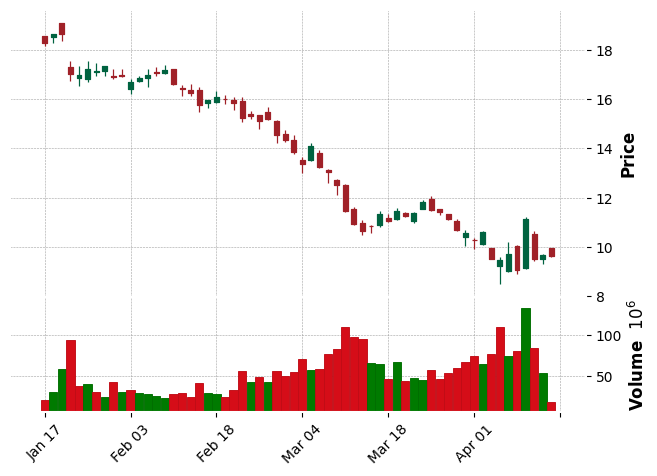

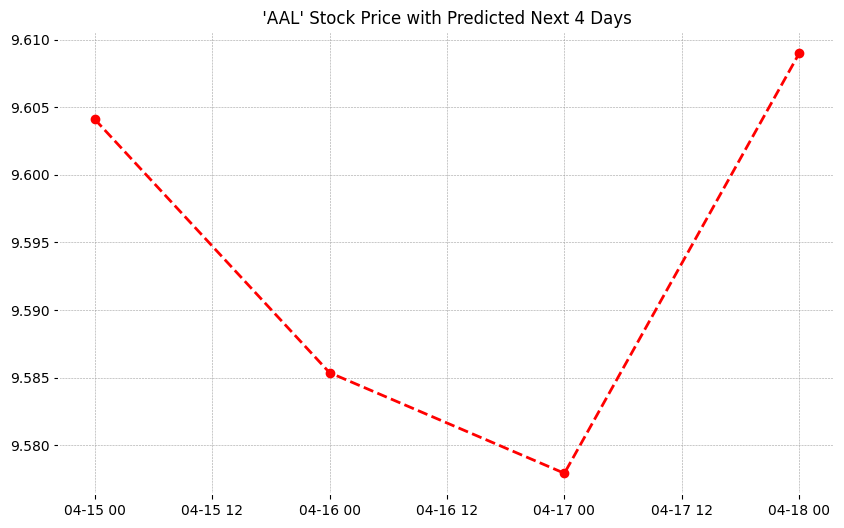

In [21]:
!pip install mplfinance -qqq
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with the fetched stock data
# Flatten multi-index columns if necessary
if isinstance(data.columns, pd.MultiIndex):
	data.columns = [col[0] for col in data.columns]

# Ensure all required columns are of type float or int
data = data.astype({'Open': 'float', 'High': 'float', 'Low': 'float', 'Close': 'float', 'Volume': 'int'})

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Assuming 'predicted_prices' is your list of predicted prices for the next 4 days
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Plotting the actual data with mplfinance
mpf.plot(data, type='candle', style='charles', volume=True)

# Overlaying the predicted data
plt.figure(figsize=(10,6))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')

plt.title(" 'AAL' Stock Price with Predicted Next 4 Days ") #change the ticker symbol as needed
plt.show()

[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


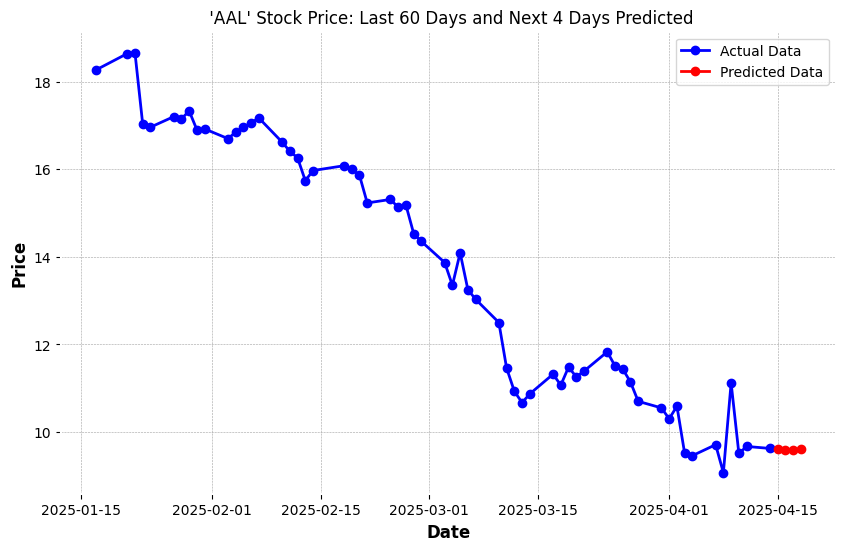

In [22]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Fetch the latest 60 days of stock data
data = yf.download('AAL', period='64d', interval='1d') # Fetch 64 days to display last 60 days in the chart # change the ticker symbol as needed

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days 
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding preds to the df
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combining actual and predicted data
combined_data = pd.concat([data['Close'], predicted_data['Close']])
combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

# Plotting the real data
plt.figure(figsize=(10,6))
plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title(" 'AAL' Stock Price: Last 60 Days and Next 4 Days Predicted") # change the ticker symbol as needed
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta


#Model to predict next 4 days of any stock price depending on the day user inputs

# Load the trained model
def predict_stock_price(input_date):
    # Check if the data is in valid date format
    try:
        input_date = pd.to_datetime(input_date)
    except ValueError:
        print("Invalid Date Format. Please enter date in YYYY-MM-DD format.")
        return

    # Get data from yfinance
    end_date = input_date
    start_date = input_date - timedelta(days=90)  # Get more days to ensure we have 60 days
    data = yf.download('AAL', start=start_date, end=end_date)

    if len(data) < 60:
        print("Not enough historical data to make a prediction. Try an earlier date.")
        return

    # Prepare the data
    closing_prices = data['Close'].values[-60:]  # Last 60 days
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))

    # Make predictions
    predicted_prices = []
    current_batch = scaled_data.reshape(1, 60, 1)

    for i in range(4):  # Predicting 4 days
        next_prediction = model.predict(current_batch)
        next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
        current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
        predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

    # Output the predictions
    for i, price in enumerate(predicted_prices, 1):
        print(f"Day {i} prediction: {price}")

# Output predictions for the next 4 days
user_input = input("Enter a date (YYYY-MM-DD) to predict 'AAL' stock for the next 4 days: ") # change the ticker symbol as needed
predict_stock_price(user_input)

[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Day 1 prediction: 13.699760437011719
Day 2 prediction: 13.68858528137207
Day 3 prediction: 13.653604507446289
Day 4 prediction: 13.65438461303711
